In [1]:
import numpy as np 
import tensorflow as tf
import tensorflow_probability as tfp
# -- diffhod --
from diffhod import diffhod
# -- plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

(-0.05, 1.1)

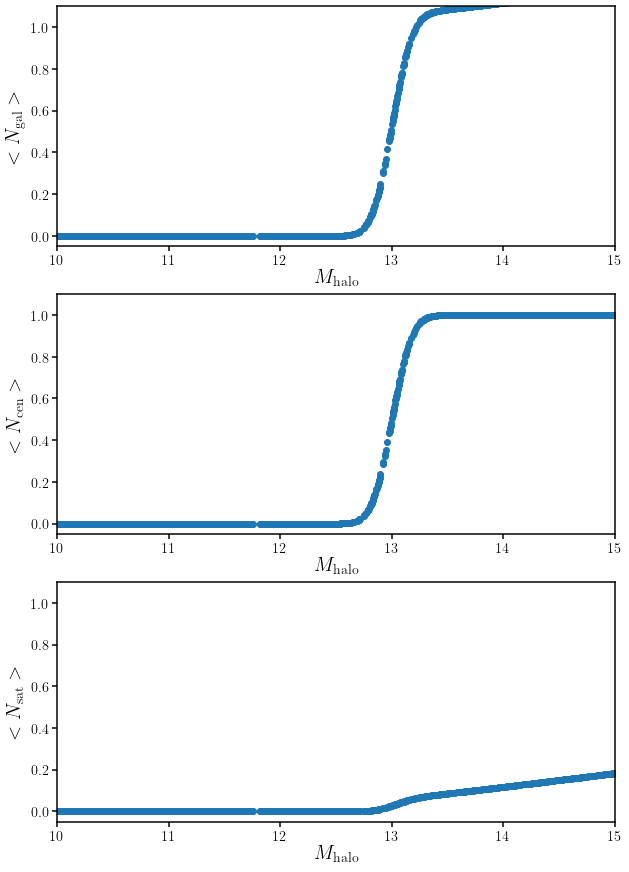

In [2]:
Mhalo = tf.convert_to_tensor(np.random.uniform(10., 15., 1000), dtype=tf.float32)

theta = tf.convert_to_tensor(np.array([13., 0.2, 12., 14., 1.1]), dtype=tf.float32)

fig = plt.figure(figsize=(10,15))
sub = fig.add_subplot(311)
sub.scatter(Mhalo, diffhod.Ncen(Mhalo, theta) + diffhod.Nsat(Mhalo, theta))
sub.set_xlabel(r'$M_{\rm halo}$', fontsize=20)
sub.set_xlim(10., 15.)
sub.set_ylabel(r'$<N_{\rm gal}>$', fontsize=20)
sub.set_ylim(-0.05, 1.1)

sub = fig.add_subplot(312)
sub.scatter(Mhalo, diffhod.Ncen(Mhalo, theta))
sub.set_xlabel(r'$M_{\rm halo}$', fontsize=20)
sub.set_xlim(10., 15.)
sub.set_ylabel(r'$<N_{\rm cen}>$', fontsize=20)
sub.set_ylim(-0.05, 1.1)

sub = fig.add_subplot(313)
sub.scatter(Mhalo, diffhod.Nsat(Mhalo, theta))
sub.set_xlabel(r'$M_{\rm halo}$', fontsize=20)
sub.set_xlim(10., 15.)
sub.set_ylabel(r'$<N_{\rm sat}>$', fontsize=20)
sub.set_ylim(-0.05, 1.1)

(-0.05, 2.1)

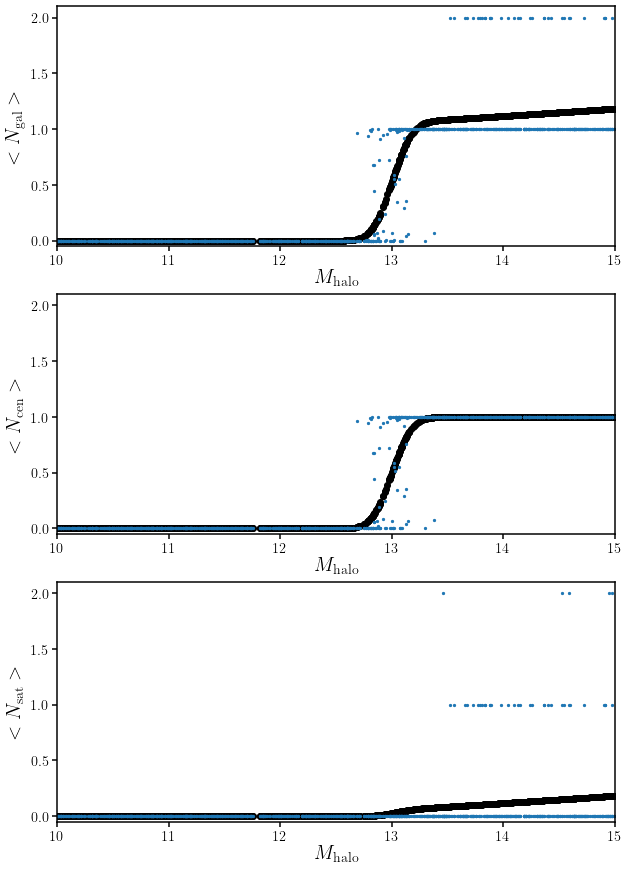

In [3]:
_ncen, _nsat = diffhod.hod(Mhalo, theta, temperature=0.2)

fig = plt.figure(figsize=(10,15))
sub = fig.add_subplot(311)
sub.scatter(Mhalo, diffhod.Ncen(Mhalo, theta) + diffhod.Nsat(Mhalo, theta), c='k')
sub.scatter(Mhalo, _ncen + _nsat, s=5)
sub.set_xlabel(r'$M_{\rm halo}$', fontsize=20)
sub.set_xlim(10., 15.)
sub.set_ylabel(r'$<N_{\rm gal}>$', fontsize=20)
sub.set_ylim(-0.05, 2.1)

sub = fig.add_subplot(312)
sub.scatter(Mhalo, diffhod.Ncen(Mhalo, theta), c='k')
sub.scatter(Mhalo, _ncen, s=5)
sub.set_xlabel(r'$M_{\rm halo}$', fontsize=20)
sub.set_xlim(10., 15.)
sub.set_ylabel(r'$<N_{\rm cen}>$', fontsize=20)
sub.set_ylim(-0.05, 2.1)

sub = fig.add_subplot(313)
sub.scatter(Mhalo, diffhod.Nsat(Mhalo, theta), c='k')
sub.scatter(Mhalo, _nsat, s=5)
sub.set_xlabel(r'$M_{\rm halo}$', fontsize=20)
sub.set_xlim(10., 15.)
sub.set_ylabel(r'$<N_{\rm sat}>$', fontsize=20)
sub.set_ylim(-0.05, 2.1)

In [4]:
def numden(_Mhalo, _theta):     
    _ncen, _nsat = diffhod.hod(_Mhalo, _theta)
    return tf.reduce_sum(_ncen + _nsat)

In [5]:
Mmin_true = 13.
siglogm_true = 0.4
M0_true = 12.
M1_true = 14.
alpha_true = 1.1
theta_true = [Mmin_true, siglogm_true, M0_true, M1_true, alpha_true]
numden_true = numden(Mhalo, theta_true).numpy()
print(numden_true)

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

_Mmin = tf.Variable(13.2, trainable=True, dtype=tf.float32)
_siglogm = tf.Variable(0.3, trainable=True, dtype=tf.float32)
_M0 = tf.Variable(12.5, trainable=True, dtype=tf.float32)
_M1 = tf.Variable(13.5, trainable=True, dtype=tf.float32)
_alpha = tf.Variable(1.3, trainable=True, dtype=tf.float32)

trainable_variables = [_Mmin, _siglogm, _M0, _M1, _alpha]

454.73898


In [6]:
mass_hist = []
for i in range(100):
    with tf.GradientTape() as tape:
        loss = (numden_true - numden(Mhalo, [_Mmin, _siglogm, _M0, _M1, _alpha]))**2
    gradients = tape.gradient(loss, trainable_variables)
    opt.apply_gradients(zip(gradients, trainable_variables))
    mass_hist.append([_Mmin.numpy(), _siglogm.numpy(), _M0.numpy(), _M1.numpy(), _alpha.numpy()])

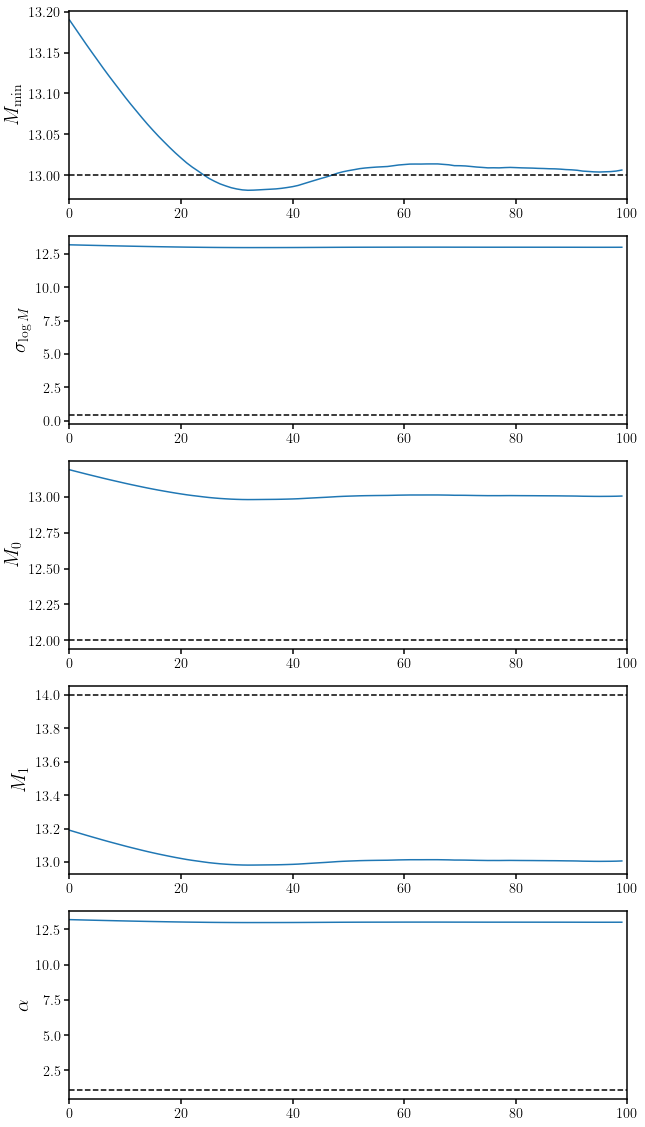

In [7]:
_true = [Mmin_true, siglogm_true, M0_true, M1_true, alpha_true]
theta_lbls = [r'$M_{\rm min}$', r'$\sigma_{\log M}$', r'$M_0$', r'$M_1$', r'$\alpha$']

fig = plt.figure(figsize=(10,20))
for i in range(5): 
    sub = fig.add_subplot(5,1,i+1)
    sub.plot(np.array(mass_hist)[:,0])
    sub.axhline(_true[i], c='k', linestyle='--')
    sub.set_xlim(0,100)
    sub.set_ylabel(theta_lbls[i], fontsize=20)

Text(0.5, 0, '$\\bar{n}$')

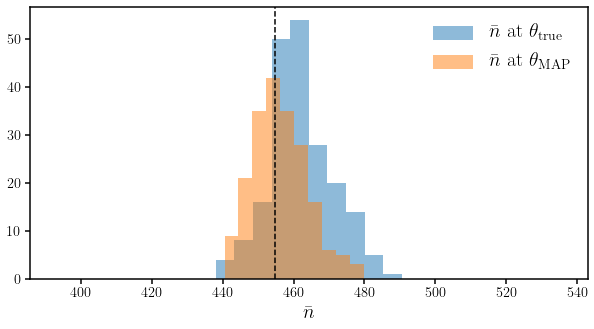

In [8]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.hist([numden(Mhalo, theta_true) for i in range(200)],alpha=0.5, label=r'$\bar{n}$ at $\theta_{\rm true}$');
sub.hist([numden(Mhalo, trainable_variables) for i in range(200)], alpha=0.5, label=r'$\bar{n}$ at $\theta_{\rm MAP}$');
sub.axvline(numden_true, color='k', linestyle='--')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'$\bar{n}$', fontsize=20)